In [7]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl (11.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 4.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 7.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



Processing language: Bengali


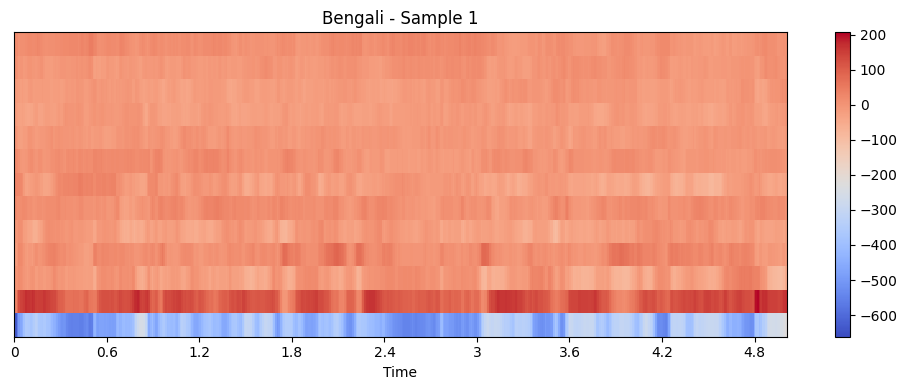

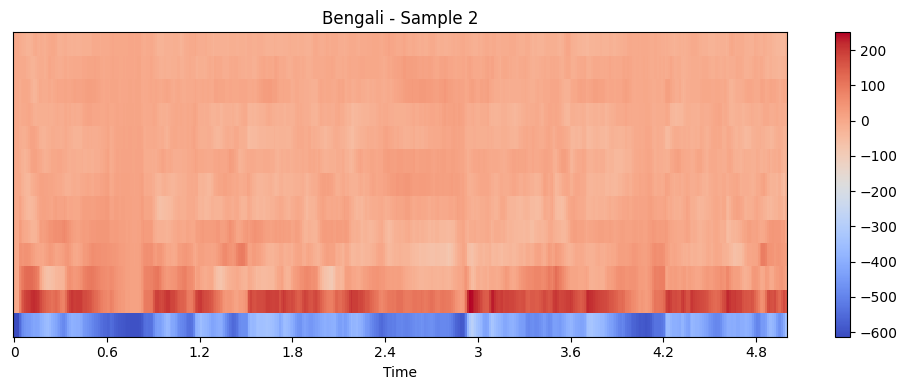

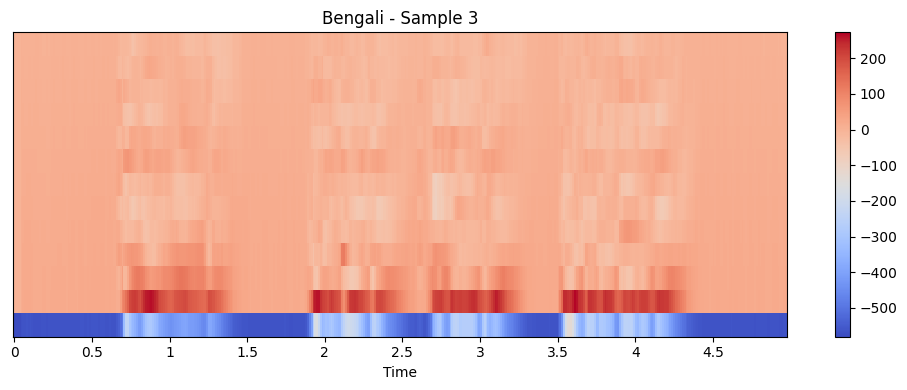


Processing language: Gujarati


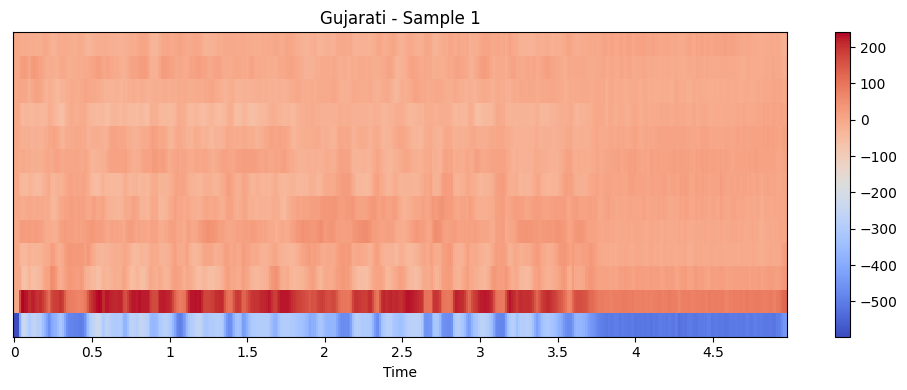

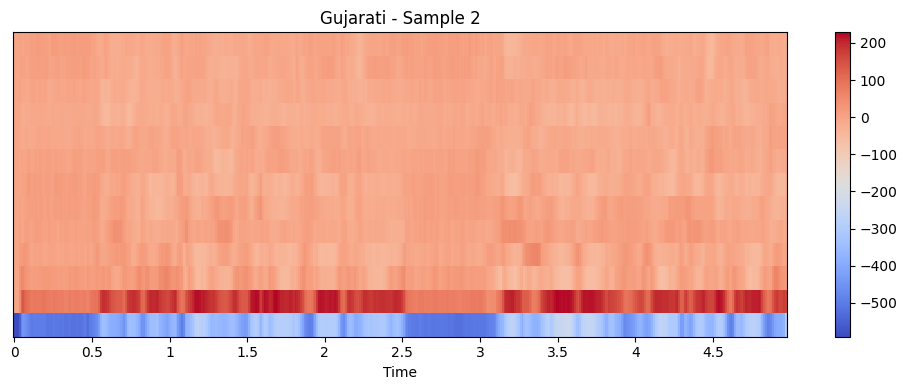

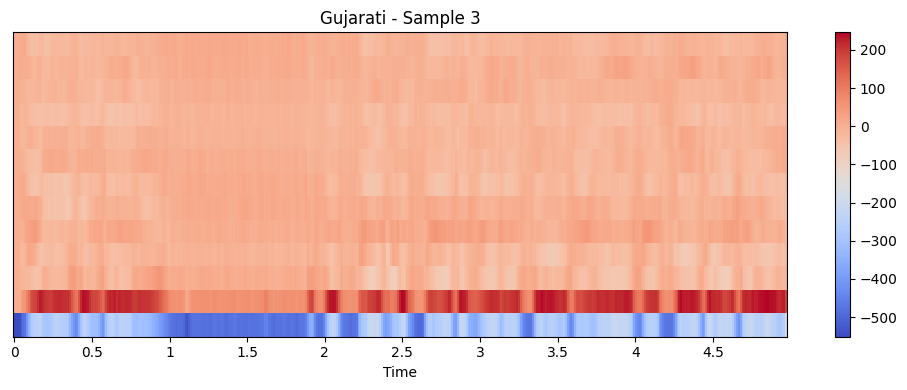


Processing language: Hindi


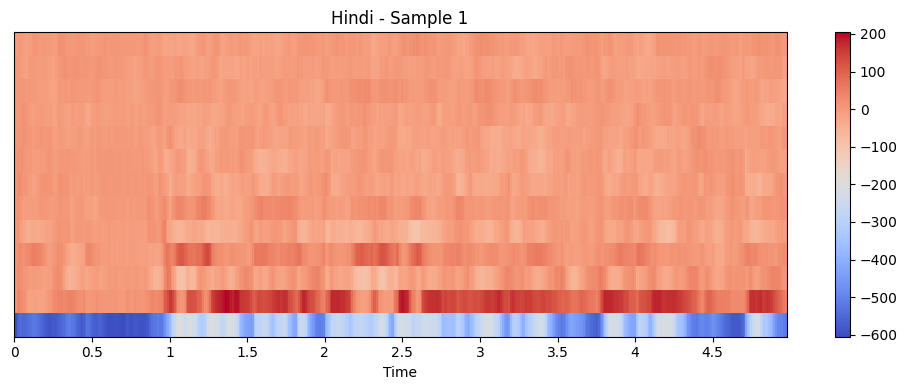

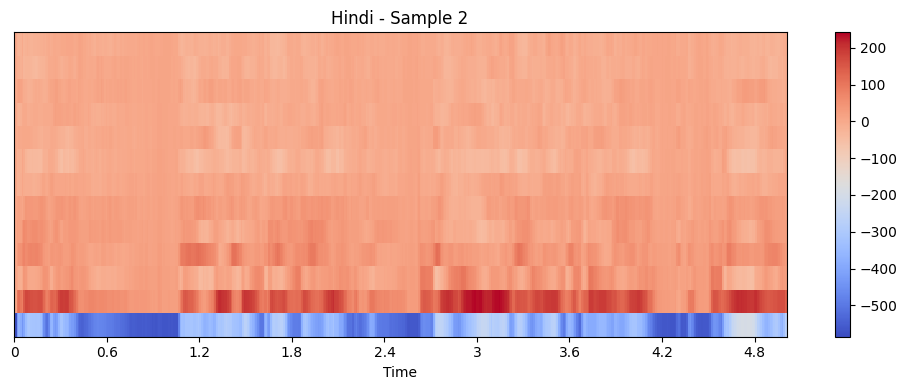

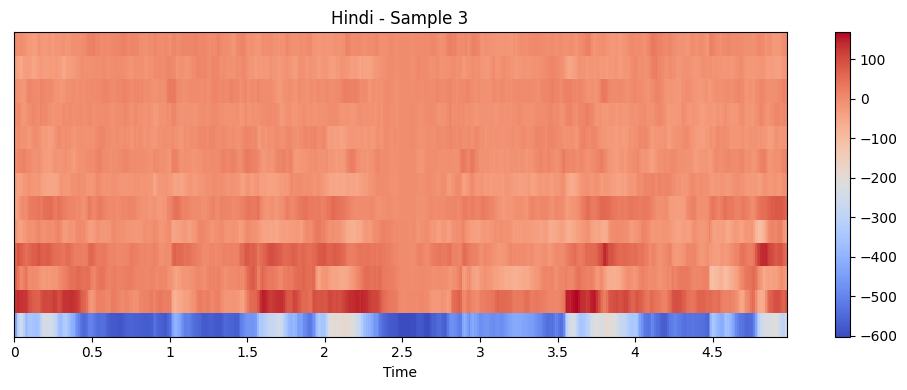

In [8]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define languages and number of samples per language to process
LANGUAGES = ["Bengali", "Gujarati", "Hindi"]
DATA_DIR = "./Language Detection Dataset"
SAMPLES_PER_LANG = 3

def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc, sr

def plot_mfcc(mfcc, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

def process_language(lang):
    print(f"\nProcessing language: {lang}")
    lang_path = os.path.join(DATA_DIR, lang)
    files = [f for f in os.listdir(lang_path) if f.endswith(".mp3")][:SAMPLES_PER_LANG]

    all_mfccs = []
    for idx, file in enumerate(files):
        file_path = os.path.join(lang_path, file)
        mfcc, sr = extract_mfcc(file_path)
        all_mfccs.append(mfcc)
        plot_mfcc(mfcc, sr, f"{lang} - Sample {idx+1}")
    
    return all_mfccs

# Main Analysis
all_language_mfccs = {}

for lang in LANGUAGES:
    mfccs = process_language(lang)
    all_language_mfccs[lang] = mfccs


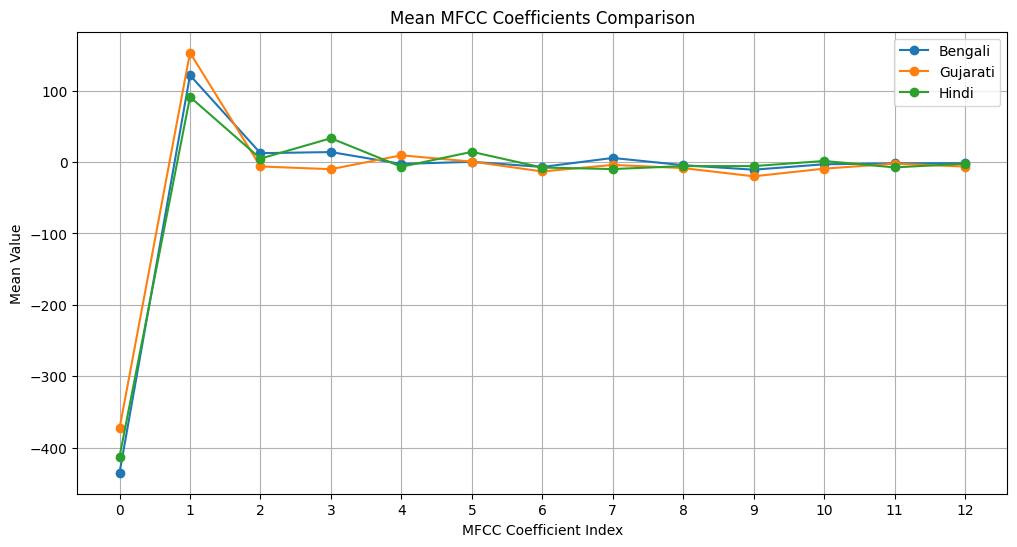

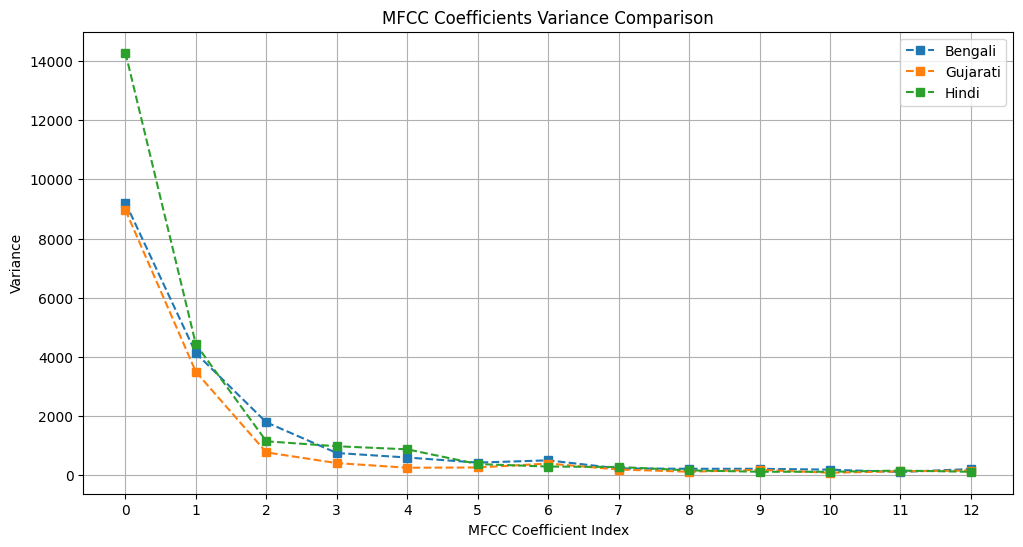


Statistical Summary:
Language   Coeff    Mean            Variance       
--------------------------------------------------
Bengali:
           MFCC 0   -435.0495       9213.2959      
           MFCC 1   121.4889        4125.3760      
           MFCC 2   12.3804         1790.4442      
           MFCC 3   13.8954         753.3688       
           MFCC 4   -2.6982         601.7871       
           MFCC 5   0.2619          429.3619       
           MFCC 6   -6.9834         506.0613       
           MFCC 7   5.6781          232.9840       
           MFCC 8   -4.4295         220.7803       
           MFCC 9   -10.7966        220.2303       
           MFCC 10  -3.1742         191.6027       
           MFCC 11  -1.9881         112.0828       
           MFCC 12  -1.7007         212.4045       
--------------------------------------------------
Gujarati:
           MFCC 0   -372.8122       8960.6914      
           MFCC 1   153.0031        3495.2673      
           MFCC 2   -6.23

In [9]:
# Statistical Analysis and Visualization

# Compute mean and variance for each language's MFCCs
language_stats = {}
for lang in LANGUAGES:
    # Combine all MFCC frames from all samples for the language
    combined_mfcc = np.hstack(all_language_mfccs[lang])
    
    # Calculate statistics
    mean_mfcc = np.mean(combined_mfcc, axis=1)
    var_mfcc = np.var(combined_mfcc, axis=1)
    
    language_stats[lang] = {
        'mean': mean_mfcc,
        'variance': var_mfcc
    }

# Plot mean MFCC comparison
plt.figure(figsize=(12, 6))
for lang in LANGUAGES:
    plt.plot(language_stats[lang]['mean'], 
             label=f'{lang}', 
             marker='o', 
             linestyle='-')
plt.title('Mean MFCC Coefficients Comparison')
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Mean Value')
plt.xticks(np.arange(13))
plt.grid(True)
plt.legend()
plt.show()

# Plot variance comparison
plt.figure(figsize=(12, 6))
for lang in LANGUAGES:
    plt.plot(language_stats[lang]['variance'], 
             label=f'{lang}', 
             marker='s', 
             linestyle='--')
plt.title('MFCC Coefficients Variance Comparison')
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Variance')
plt.xticks(np.arange(13))
plt.grid(True)
plt.legend()
plt.show()

# Tabular comparison
print("\nStatistical Summary:")
print("{:<10} {:<8} {:<15} {:<15}".format(
    'Language', 'Coeff', 'Mean', 'Variance'))
print("-"*50)

for lang in LANGUAGES:
    print(f"{lang}:")
    for i in range(13):
        print("{:<10} {:<8} {:<15.4f} {:<15.4f}".format(
            '', 
            f'MFCC {i}', 
            language_stats[lang]['mean'][i], 
            language_stats[lang]['variance'][i]
        ))
    print("-"*50)


Classification Report:
               precision    recall  f1-score   support

       Hindi       1.00      1.00      1.00        20
    Gujarati       1.00      0.85      0.92        20
     Bengali       0.87      1.00      0.93        20

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



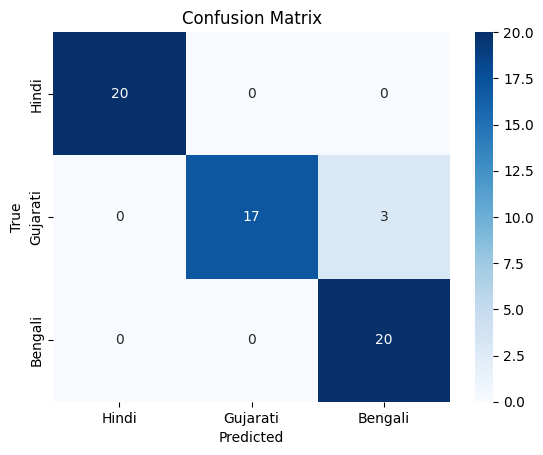

In [10]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

LANGUAGES = ["Hindi", "Gujarati", "Bengali"]
DATA_DIR = "./Language Detection Dataset"
N_MFCC = 13
SAMPLES_PER_LANG = 100  # or max available

def extract_features(lang_dir, label):
    features = []
    labels = []
    files = [f for f in os.listdir(lang_dir) if f.endswith(".mp3")][:SAMPLES_PER_LANG]
    for f in files:
        path = os.path.join(lang_dir, f)
        y, sr = librosa.load(path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        mfcc_mean = np.mean(mfcc, axis=1)  # shape: (13,)
        features.append(mfcc_mean)
        labels.append(label)
    return features, labels

# Step 1: Load and process data
X, y = [], []
for i, lang in enumerate(LANGUAGES):
    lang_dir = os.path.join(DATA_DIR, lang)
    feats, lbls = extract_features(lang_dir, i)
    X.extend(feats)
    y.extend(lbls)

X = np.array(X)
y = np.array(y)

# Step 2: Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Model training
clf = SVC(kernel='rbf', C=1, gamma='scale')  # you can try RandomForest or MLP as well
clf.fit(X_train, y_train)

# Step 5: Evaluation
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=LANGUAGES))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LANGUAGES, yticklabels=LANGUAGES, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
